In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.utils.data
import torchvision
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from icecream import ic
from collections import Counter

In [2]:
import sys
path = r"../Data/raw"
image_addr_list = os.listdir(path)

#### Read Sample Image

ic| img.shape: (674, 1000, 3)
ic| clipped_img.shape: (200, 750, 3)


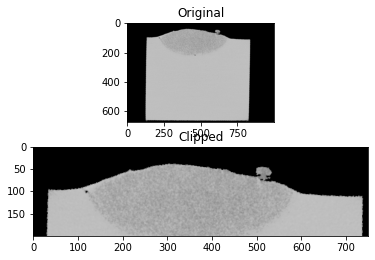

In [3]:
sample_addr = image_addr_list[100]
full_path = os.path.join(path, sample_addr)
imgobj = Image.open(full_path).convert('RGB')
# Show original images
img = np.asarray(imgobj)
ic(img.shape)
# Clip images
clipped_img = img[0:200,100:850]
ic(clipped_img.shape)
# Plot results
titles = ['Original', 'Clipped']
for idx, img in enumerate([img, clipped_img]):
    plt.subplot(2, 1,idx+1), plt.imshow(img,'gray',vmin=0,vmax=255)
    plt.title(titles[idx])

#### Clip all images [Rerun if necessary]

In [9]:
ic(len(image_addr_list))
process = True
if process:
    for i in tqdm(image_addr_list):
        full_path = os.path.join(path, i)
        img = Image.open(full_path).convert('RGB')
        img_array = np.asarray(img)
        img_ = Image.fromarray(img_array[0:250,120:850], 'RGB')
        img_.save('../Data/clipped/' + i)

ic| len(image_addr_list): 4046


  0%|          | 0/4046 [00:00<?, ?it/s]

In [12]:
ic(len(image_addr_list))
ic(len(os.listdir("../Data/clipped")))

ic| len(image_addr_list): 4046
ic| len(os.listdir("../Data/clipped")): 4046


4046

In [13]:
assert len(os.listdir("../Data/clipped/")) == len(image_addr_list)

#### Denoising

##### Denoise a single sample image

In [14]:
import cv2 as cv

ic| clipped_img.shape: (200, 750, 3)
ic| thresh1.shape: (200, 750)
ic| ret: 0.0


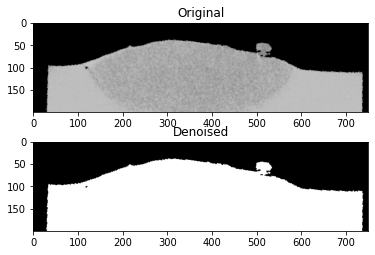

In [82]:
# Original images
ic(clipped_img.shape)
# plt.imshow(clipped_img)
# Thresholding the original images
bi_img = cv.cvtColor(clipped_img, cv.COLOR_BGR2GRAY)
ret, thresh1 = cv.threshold(bi_img, 255, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
ic(thresh1.shape)
ic(ret)
# Plot results
titles = ['Original', 'Denoised']
for idx, img in enumerate([clipped_img, thresh1]):
    plt.subplot(2, 1,idx+1), plt.imshow(img,'gray',vmin=0,vmax=255)
    plt.title(titles[idx])

##### Denoising all images

In [15]:
process=False
if process:
    for i in tqdm(image_addr_list):
        full_path = os.path.join(path, i)
        img = Image.open(full_path).convert('RGB')
        img_array = np.asarray(img)
        # Clip
        img_ = Image.fromarray(img_array[0:250,120:850], 'RGB')
        img_ = cv.cvtColor(np.asarray(img_), cv.COLOR_BGR2GRAY)
        # Denoise
        ret, thresh1 = cv.threshold(img_, 255, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) 
        Image.fromarray(thresh1).save('../Data/processed/' + i)
assert len(os.listdir("../Data/processed/")) == len(image_addr_list)

#### Find Contour & Bounding Boxes

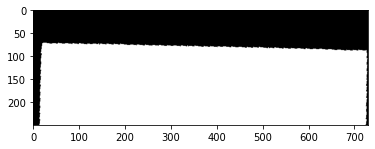

In [41]:
path = "../Data/processed/"
image_addr_list = os.listdir(path)
sample_addr = image_addr_list[0]
full_path = os.path.join(path, sample_addr)
imgobj = Image.open(full_path).convert('RGB')
# Show original images
raw_img = np.asarray(imgobj)
plt.imshow(raw_img)

In [42]:
import cv2 as cv
img0 = cv.cvtColor(raw_img,cv.COLOR_BGR2GRAY)
contours, hierarchy = cv.findContours(img0,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

ic| len(contours): 1
ic| item.shape: (451, 1, 2)


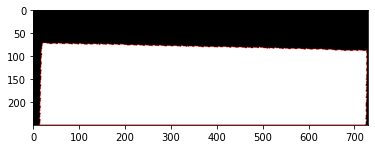

In [43]:
ic(len(contours))
for item in contours:
    ic(item.shape)
# plt.imshow(Image.fromarray(cv.drawContours(img0, contours,-1,(255,0,0),1)))
contour_img = Image.fromarray(cv.drawContours(raw_img, contours,-1,(255,0,0),1))
plt.imshow(contour_img)

ic| bb: (14, 71, 715, 179)


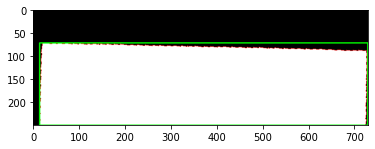

In [46]:
p = []
for item in contours:
    bb = cv.boundingRect(item)
    ic(bb)
    x,y,w,h = bb
    p.append(Image.fromarray(cv.rectangle(raw_img,(x,y),(x+w,y+h),(0,255,0),2)))
# Plot
plt.imshow(raw_img)


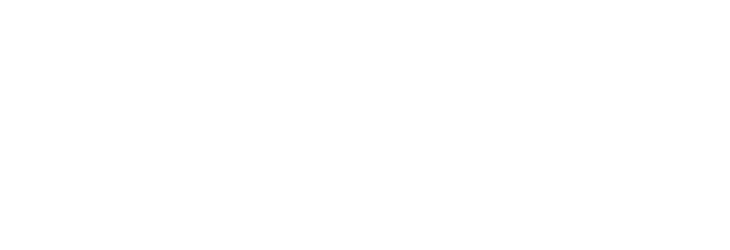

In [48]:
mask = np.ones(raw_img.shape[:2],dtype=np.uint8) * 255
Image.fromarray(cv.drawContours(mask, [], -1, (0,255,255), -1))

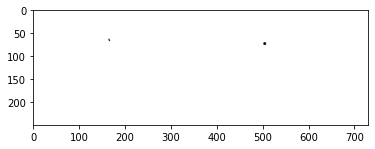

In [40]:
plt.imshow(cv.drawContours(mask, [contours[1], contours[2], contours[3]], -1, (0,255,255), -1),'gray')

##### Process all data with bounding boxes

In [50]:
# Wrap this into a .py function in contour.py
process = False
if process:
    num_defects = []
    min_area, max_area = 20, 20000
    for i in tqdm(image_addr_list):
        full_path = os.path.join(path, i)
        imgobj = Image.open(full_path).convert('RGB')
        img = np.asarray(imgobj)
        # Convert to grayscale images
        grayimg = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        # Find contours
        contours, hierarchy = cv.findContours(grayimg,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

        num_poles = 0
        valid_contours = []
        # Loop through each contour to inspect
        for j in range(len(contours)):
            x, y, w, h = cv.boundingRect(contours[j])
            # Middle point must be black
            if grayimg[int(y+h/2), int(x+w/2)] == 0:
                # Pole can not be too close to the boundary
                if grayimg[int(max(y-h/2, 0)), int(x+w/2)] != 0:
                    # Pole should be large enough but not too big
                    if h*w > min_area and h*w < max_area:
                        num_poles += 1
                        valid_contours.append(contours[j])
        num_defects.append(num_poles)
        # Save to processed
        mask = np.ones(raw_img.shape[:2],dtype=np.uint8) * 255
        img_arr = cv.drawContours(mask, valid_contours, -1, (0,255,255), -1)
        Image.fromarray(img_arr).save('../Data/final/' + i)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [68]:
assert len(os.listdir("../Data/final/")) == len(image_addr_list)
assert len(num_defects) == len(image_addr_list)
torch.save(image_addr_list, "../Data/label/order.pt")
torch.save(num_defects, "../Data/label/num_defects.pt")

In [67]:
# Label: 1 -> has defects; 0 -> no defects
label = np.where(np.array(num_defects) == 0, 0, 1)
assert len(num_defects) == len(label)
assert np.sum(label) == np.sum(np.array(num_defects) != 0)
torch.save(torch.tensor(label), "../Data/label/label.pt")

#### Load sample data

In [73]:
full_path = os.path.join("../Data/final/", image_addr_list[100])
imgobj = Image.open(full_path).convert('L')
img = np.asarray(imgobj)
ic(img.shape)

ic| img.shape: (250, 730)


(250, 730)